In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from Methods import EstimationMethods
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def get_split(simulation: pd.DataFrame) -> tuple[pd.DataFrame]:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]]
    T_train = train_df['T']
    Y_train = train_df['y']

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]]
    T_test = test_df['T']
    y_test = test_df['y']

    true_cate_train = train_df[['CATE', 'T']]
    true_cate_test = test_df[['CATE', 'T']]

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_train, true_cate_test

In [3]:
def mse_analysis(ols: bool = False, t_learner: bool = False, cf_dml: bool = False, npm: bool = False) -> pd.DataFrame:

    mean_mse_dict_train = {}
    ind_mse_lis_train = []
    mean_mse_dict_test = {}
    ind_mse_lis_test = []



    for n in tqdm(range(500, 2001, 100)):
        for i in range(5):
        
            sim: SimulationStudy = SimulationStudy(p=20, mean_correlation=0.5, cor_variance=0.05, n=n, no_feat_cate=5, non_linear=True)
            simulation = sim.create_dataset()
            train_df, test_df, X_train, Y_train, T_train, X_test, T_test, Y_test, train_cate_test, true_cate_test = get_split(simulation)
            
            estimators: EstimationMethods = EstimationMethods(X_train, T_train, Y_train, X_test, T_test, Y_test, train_cate_test, true_cate_test)

            if ols is True:
                estimated_cate_train, estimated_cate_test, MSE_train, MSE_test = estimators.ols_estimator()
            elif t_learner is True:
                estimated_cate_train, estimated_cate_test, MSE_test, MSE_train = estimators.TLearner_estimator()
            elif cf_dml is True:
                estimated_cate_train, estimated_cate_test, MSE_test, MSE_train = estimators.CF_DML()
            elif npm is True:
                estimated_cate_train, estimated_cate_test, MSE_test, MSE_train = estimators.non_param_dml()
            else:
                print('Chose either ols, t_learner, cf_dml, or npm.')

            ind_mse_lis_train.append(MSE_train)
            ind_mse_lis_test.append(MSE_test)
        
        mean_mse_train = np.array(ind_mse_lis_train)
        mean_mse_train = np.mean(mean_mse_train)

        mean_mse_test = np.array(ind_mse_lis_test)
        mean_mse_test = np.mean(mean_mse_test)

        key = f'{n}'
        mean_mse_dict_train[key] = mean_mse_train
        mean_mse_dict_test[key] = mean_mse_test


        mse_df = pd.DataFrame()
        mse_df['n'] = mean_mse_dict_train.keys()
        mse_df['MSE Train'] = mean_mse_dict_train.values()
        mse_df['MSE Test'] = mean_mse_dict_test.values()


    return mse_df


In [4]:
mse_ols = mse_analysis(ols=True)
mse_t = mse_analysis(t_learner=True)
mse_cf_dml = mse_analysis(cf_dml=True)
#mse_npm = mse_analysis(npm=True)

100%|██████████| 16/16 [20:44<00:00, 77.76s/it] 


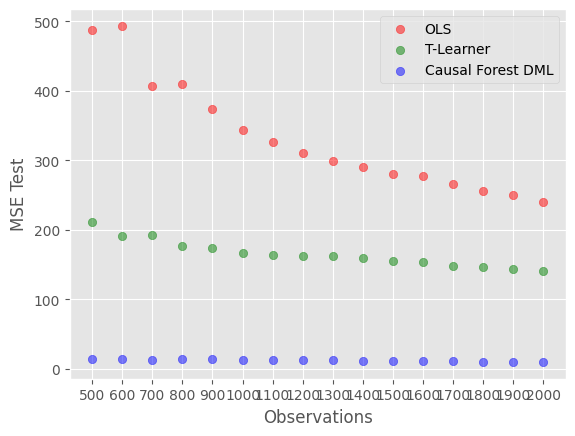

In [8]:

# Use the n values to set the ticks
# Create the scatter plot
plt.style.use('ggplot')
plt.scatter(mse_ols['n'], mse_ols['MSE Test'], alpha=0.5, color='red', label='OLS')
plt.scatter(mse_t['n'], mse_t['MSE Test'], alpha=0.5, color='green', label='T-Learner')
plt.scatter(mse_cf_dml['n'], mse_cf_dml['MSE Test'], alpha=0.5, color='blue', label='Causal Forest DML')
#plt.scatter(mse_npm['n'], mse_npm['MSE'], alpha=0.5, color='yellow', label='Non-Parametric DML')

# Set the x-ticks and y-ticks
#plt.xticks([])
# Set labels and legend
plt.xlabel('Observations')
plt.ylabel('MSE Test')
plt.legend()

# Show the plot
plt.show()